In [1]:
# Use cuda backend for networkx
# Requires to run this first:
# pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com
# %env NX_CUGRAPH_AUTOCONFIG=True


In [2]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare

from src.data.some_dataloader import *
from articles_clicks_links import click_count_in_paths

In [3]:
links_df = load_links_dataframe()

links_df

,linkSource,linkTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
...,...,...
119877,Zulu,South_Africa
119878,Zulu,Swaziland
119879,Zulu,United_Kingdom
119880,Zulu,Zambia


In [4]:
mystery_article = 'Wikipedia_Text_of_the_GNU_Free_Documentation_License' # All pages have a link to this page at the bottom, but it has no links out, so it is a dead-end. Still, a lot of people (128 or sth) clicked on it and then went back. However, in the wikipedia graph this article is not considered to be linked to any article (it makes sense, otherwise it would have a link to ALL articles). Thus click counts to this article must be removed, otherwise it will cause issues when computing chi-square (expected frequency = pagerank = 0 but real frequency > 0 causes NaN pvalue (this is impossible to generate such a distribution if expected frequency is 0 in Multinomial)
mystery_article_2 = 'Private_Peaceful' # One guy was instantiated there and since this article has no links out, it was an unfinished path of length 1
# This shows that the start article (and end article) are not really representative of the player's behavior, i.e. they should / cannot really be compared with pagerank. A player can be instantiated on an isolated vertices, which won't happen with pagerank. This caused issues when computing chi-square, plus it would bias our results towards showing higher click rates for articles that are start / end articles in the game, although the player did not choose to click on them.

# Thus we:
# 1. remove mystery_article in the click_counts so that it is considered to be not even part of the graph (as it should be)
# 2. remove start (and for finished_paths also end) articles from the paths before computing click counts so are results are less biased (otherwise they show a lot of the start / target as higher positive difference in player ranks, for no reason other than the fact that they are used by the game)

In [5]:
len(links_df)

119882

In [6]:
edges = [(row['linkSource'], row['linkTarget']) for index, row in links_df.iterrows()]
G = nx.DiGraph(edges)

In [7]:
truncated_edges = [(row['linkSource'], row['linkTarget']) for index, row in links_df.head(1000).iterrows()]
truncated_G = nx.DiGraph(truncated_edges)

In [8]:
truncated_pagerank = nx.pagerank(truncated_G)
truncated_pagerank

{'%C3%81ed%C3%A1n_mac_Gabr%C3%A1in': 0.0016279605036263532,
 'Bede': 0.0017537671871455235,
 'Columba': 0.0017537671871455235,
 'D%C3%A1l_Riata': 0.001892154539016611,
 'Great_Britain': 0.001892154539016611,
 'Ireland': 0.002222859509574436,
 'Isle_of_Man': 0.0017995018573894964,
 'Monarchy': 0.0018119473074529487,
 'Orkney': 0.0017537671871455235,
 'Picts': 0.0017537671871455235,
 'Scotland': 0.0020290711594543815,
 'Wales': 0.0017537671871455235,
 '%C3%85land': 0.0016279605036263532,
 '20th_century': 0.0018529914034421094,
 'Baltic_Sea': 0.001700795951979557,
 'Crimean_War': 0.0017108238955587302,
 'Currency': 0.001700795951979557,
 'Euro': 0.001700795951979557,
 'European_Union': 0.0017302400693989374,
 'Finland': 0.0018010175411465796,
 'League_of_Nations': 0.001700795951979557,
 'List_of_countries_by_system_of_government': 0.001700795951979557,
 'Nationality': 0.001700795951979557,
 'Parliamentary_system': 0.001700795951979557,
 'Police': 0.001700795951979557,
 'Russia': 0.0017709

In [9]:
pagerank = nx.pagerank(G)
pagerank

{'%C3%81ed%C3%A1n_mac_Gabr%C3%A1in': 3.2710390395592254e-05,
 'Bede': 0.00021938161316650256,
 'Columba': 0.00012116881897593145,
 'D%C3%A1l_Riata': 0.00010556015467803797,
 'Great_Britain': 0.0015061292462843425,
 'Ireland': 0.0018999654148516224,
 'Isle_of_Man': 0.00046032088563309313,
 'Monarchy': 0.0008133221072287704,
 'Orkney': 0.00028994588516574057,
 'Picts': 0.00019759121101826143,
 'Scotland': 0.0021425304277849183,
 'Wales': 0.0010997632074287427,
 '%C3%85land': 3.2710390395592254e-05,
 '20th_century': 0.002361539066403613,
 'Baltic_Sea': 0.0006497932466591777,
 'Crimean_War': 0.00022012926646383522,
 'Currency': 0.003237155919656553,
 'Euro': 0.001249533710187169,
 'European_Union': 0.002318582455038707,
 'Finland': 0.001009621435681574,
 'League_of_Nations': 0.0005769703027683626,
 'List_of_countries_by_system_of_government': 0.0028333266533963103,
 'Nationality': 0.00022617861790487603,
 'Parliamentary_system': 0.000721430277649281,
 'Police': 0.00025282362854375833,
 'Ru

In [10]:
pagerank_df = pd.DataFrame({
    'article_name': pagerank.keys(),
    'rank': pagerank.values() # Order will correspond to keys
})
pagerank_df.sort_values(by='rank', ascending=False, inplace=True, ignore_index=True)
pagerank_df

,article_name,rank
0,United_States,0.009566
1,France,0.006423
2,Europe,0.006340
3,United_Kingdom,0.006235
4,English_language,0.004865
...,...,...
4587,Grange_Hill,0.000033
4588,Grand_Central_Station_%28Chicago%29,0.000033
4589,Gowanus_Canal,0.000033
4590,Gordon_Griffith,0.000033


In [11]:
articles = load_articles_dataframe()
articles

,articles
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts
...,...
4599,Zionism
4600,Zirconium
4601,Zoroaster
4602,Zuid-Gelders


In [12]:
finished_paths = load_path_finished_dataframe()
unfinished_paths = load_path_unfinished_distance_dataframe()
paths_merged = pd.concat([finished_paths["path"].apply(lambda row: row.split(';')[1:-1]), unfinished_paths["path"].apply(lambda row: row.split(';')[1:])])
# Remove first article as it could be an article with no links and thus have a pagerank of 0 while not having a click_count of 0. This causes issues when computing chi-square test, and also biases the results since start articles are not actually chosen by players, they don't really _click_ on it
# Also remove last article for finished path, since again, it is not chosen by player

paths_merged

0        [15th_century, 16th_century, Pacific_Ocean, At...
1                   [Europe, Africa, Atlantic_slave_trade]
2        [Niger, Nigeria, British_Empire, Slavery, Afri...
3                            [Renaissance, Ancient_Greece]
4        [Italy, Roman_Catholic_Church, HIV, Ronald_Rea...
                               ...                        
24870    [Tuberculosis, World_Health_Organization, Mala...
24871                                                   []
24872           [Linguistics, Culture, Popular_culture, <]
24873     [United_Kingdom, World_War_II, Battle_of_Midway]
24874                   [Rome, Tennis, Hawk-Eye, Computer]
Name: path, Length: 76193, dtype: object

In [13]:
df_clicks = click_count_in_paths(articles, paths_merged)
df_clicks = df_clicks[df_clicks.index != mystery_article] # Remove GNU license as it is not supposed to be counted as actual clicks
df_clicks

there are 348573 clicks in the whole whikispeedia dataset (both finished and unfinished paths)


,click_count
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,0
%C3%85land,4
%C3%89douard_Manet,7
%C3%89ire,13
%C3%93engus_I_of_the_Picts,0
...,...
Zionism,8
Zirconium,4
Zoroaster,5
Zuid-Gelders,0


In [14]:
df_player_frequencies = df_clicks.copy()
df_player_frequencies.click_count = df_player_frequencies.click_count / df_player_frequencies.click_count.sum()
df_player_frequencies.rename(columns={'click_count': 'rank'}, inplace=True)
df_player_frequencies.index.name = 'article_name'
df_player_frequencies.reset_index(inplace=True)
df_player_frequencies.sort_values(by='rank', ascending=False, inplace=True, ignore_index=True)

df_player_frequencies

,article_name,rank
0,United_States,0.039272
1,Europe,0.017629
2,United_Kingdom,0.016756
3,England,0.013664
4,Earth,0.013124
...,...,...
4598,Canaletto,0.000000
4599,Nathu_La,0.000000
4600,Cape_Porcupine,0.000000
4601,Nanomedicine,0.000000


In [15]:
df_player_frequencies['rank'].sum()

1.0

In [16]:
df_player_frequencies['type'] = 'Player'
pagerank_df['type'] = 'Pagerank'
rank_v_freq = pd.concat([df_player_frequencies, pagerank_df], ignore_index=True)
rank_v_freq.sort_values(by=['type', 'rank'], ignore_index=True, inplace=True, ascending=[True, False])
rank_v_freq

,article_name,rank,type
0,United_States,0.009566,Pagerank
1,France,0.006423,Pagerank
2,Europe,0.006340,Pagerank
3,United_Kingdom,0.006235,Pagerank
4,English_language,0.004865,Pagerank
...,...,...,...
9190,Canaletto,0.000000,Player
9191,Nathu_La,0.000000,Player
9192,Cape_Porcupine,0.000000,Player
9193,Nanomedicine,0.000000,Player


In [17]:
draw_first_k = 80
first_k_article_names = pagerank_df.head(draw_first_k).article_name
truncated_r_v_f = rank_v_freq[rank_v_freq.article_name.isin(first_k_article_names.values)].reset_index(drop=True)
truncated_r_v_f

,article_name,rank,type
0,United_States,0.009566,Pagerank
1,France,0.006423,Pagerank
2,Europe,0.006340,Pagerank
3,United_Kingdom,0.006235,Pagerank
4,English_language,0.004865,Pagerank
...,...,...,...
155,Portugal,0.000781,Player
156,Poland,0.000733,Player
157,Belgium,0.000692,Player
158,List_of_countries_by_system_of_government,0.000664,Player


<Axes: xlabel='rank', ylabel='article_name'>

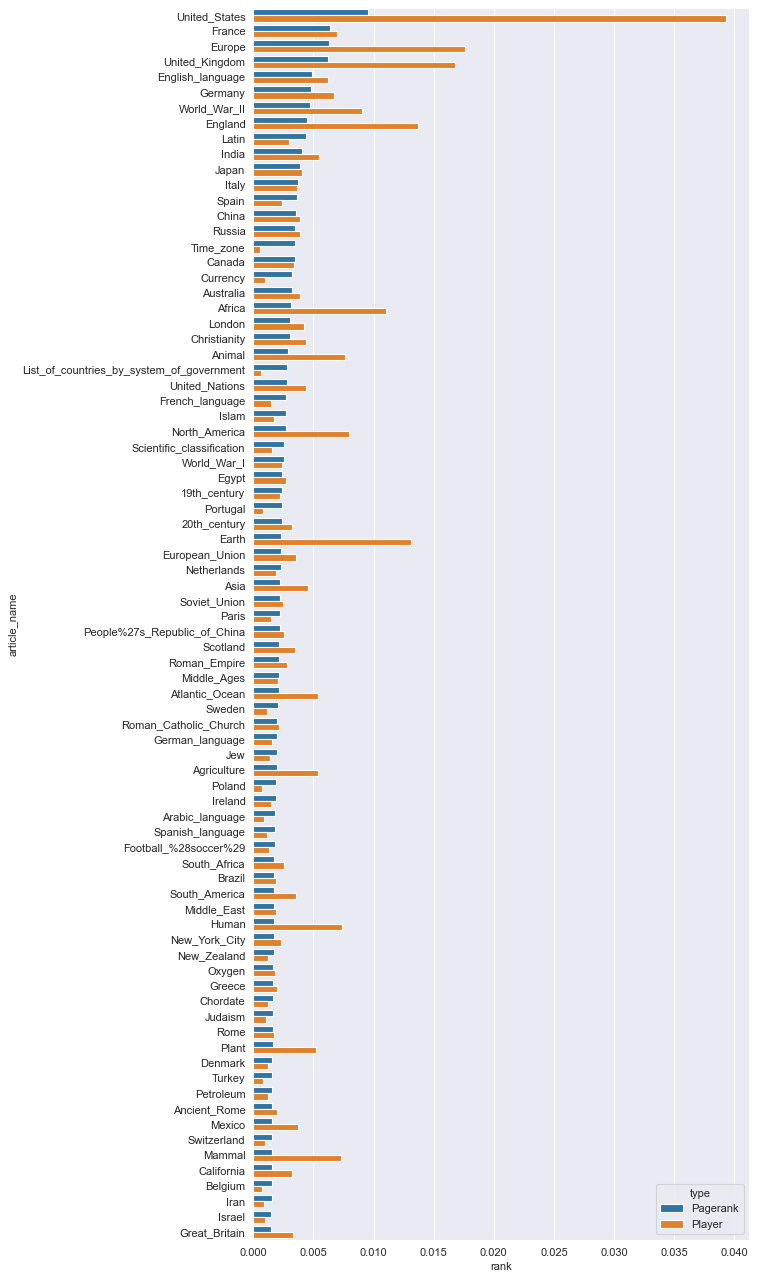

In [18]:
plt.figure(figsize=(8, 20), dpi=80)
sns.barplot(truncated_r_v_f, y='article_name', x='rank', hue='type', orient='y')

In [19]:
# Assert that all those articles have rank 0 for chi-square to work !
df_player_frequencies[~df_player_frequencies['article_name'].isin(pagerank_df['article_name'].values)]

,article_name,rank,type
3629,Vacutainer,0.0,Player
3667,Underground_%28stories%29,0.0,Player
3832,Suikinkutsu,0.0,Player
3837,Wowpurchase,0.0,Player
4145,Donation,0.0,Player
4147,Douglas_DC-4,0.0,Player
4299,Private_Peaceful,0.0,Player
4402,Badugi,0.0,Player
4403,Schatzki_ring,0.0,Player
4472,Color_Graphics_Adapter,0.0,Player


In [20]:
rank_v_freq_2_columns = pd.merge(pagerank_df[['article_name', 'rank']], df_player_frequencies[['article_name', 'rank']], on='article_name', suffixes=('_pagerank', '_players'), how='right')
rank_v_freq_2_columns.sort_values(by='rank_pagerank', inplace=True, ignore_index=True, ascending=False)
rank_v_freq_2_columns

,article_name,rank_pagerank,rank_players
0,United_States,0.009566,0.039272
1,France,0.006423,0.006988
2,Europe,0.006340,0.017629
3,United_Kingdom,0.006235,0.016756
4,English_language,0.004865,0.006210
...,...,...,...
4598,Private_Peaceful,NaN,0.000000
4599,Badugi,NaN,0.000000
4600,Schatzki_ring,NaN,0.000000
4601,Color_Graphics_Adapter,NaN,0.000000


In [21]:
rank_v_freq_2_columns = rank_v_freq_2_columns.fillna(0) # fill missing pagerank values (those where isolated articles that were not added to the graph, they all have click_count 0 anyway and the pagerank should be 0 too)
rank_v_freq_2_columns

,article_name,rank_pagerank,rank_players
0,United_States,0.009566,0.039272
1,France,0.006423,0.006988
2,Europe,0.006340,0.017629
3,United_Kingdom,0.006235,0.016756
4,English_language,0.004865,0.006210
...,...,...,...
4598,Private_Peaceful,0.000000,0.000000
4599,Badugi,0.000000,0.000000
4600,Schatzki_ring,0.000000,0.000000
4601,Color_Graphics_Adapter,0.000000,0.000000


<Axes: xlabel='article_name'>

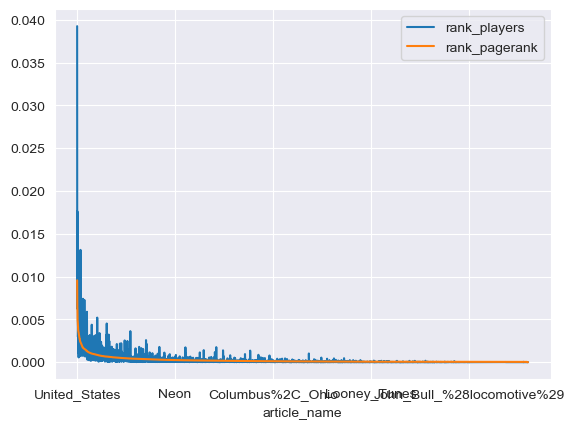

In [22]:
ax = rank_v_freq_2_columns.plot(x='article_name', y='rank_players')
rank_v_freq_2_columns.plot(x='article_name', y='rank_pagerank', ax=ax)

In [23]:
rank_v_freq_2_columns['rank_diff'] = rank_v_freq_2_columns['rank_players'] - rank_v_freq_2_columns['rank_pagerank']
rank_v_freq_by_diff = rank_v_freq_2_columns.sort_values(by='rank_diff', ascending=False)
rank_v_freq_by_diff

,article_name,rank_pagerank,rank_players,rank_diff
0,United_States,0.009566,0.039272,0.029706
2,Europe,0.006340,0.017629,0.011290
34,Earth,0.002348,0.013124,0.010777
3,United_Kingdom,0.006235,0.016756,0.010522
7,England,0.004474,0.013664,0.009190
...,...,...,...,...
8,Latin,0.004424,0.002956,-0.001468
32,Portugal,0.002378,0.000781,-0.001597
23,List_of_countries_by_system_of_government,0.002833,0.000664,-0.002170
17,Currency,0.003237,0.000997,-0.002240


<Axes: xlabel='rank_diff', ylabel='article_name'>

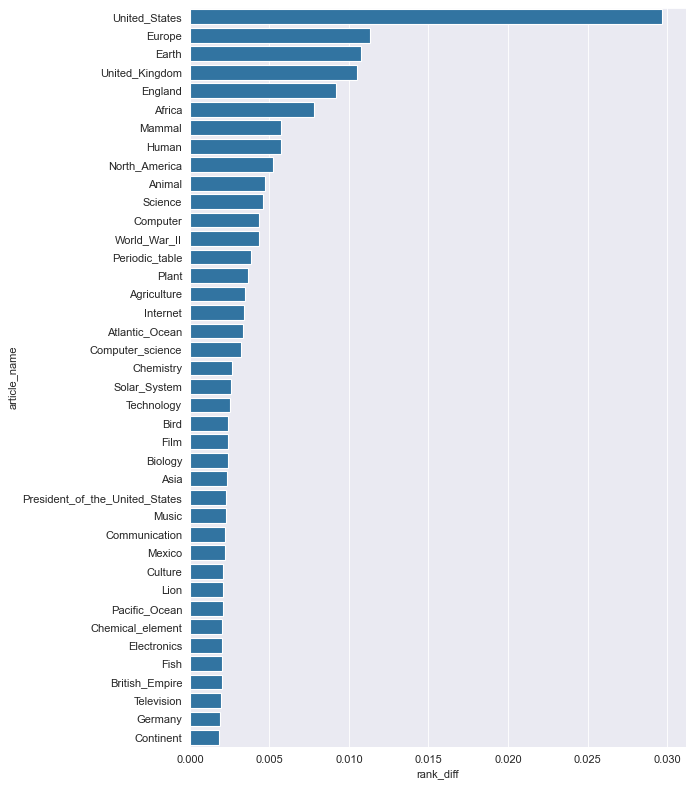

In [24]:
plt.figure(figsize=(8, 12), dpi=80)
sns.barplot(rank_v_freq_by_diff.head(40), y='article_name', x='rank_diff', orient='y')

<Axes: xlabel='rank_diff', ylabel='article_name'>

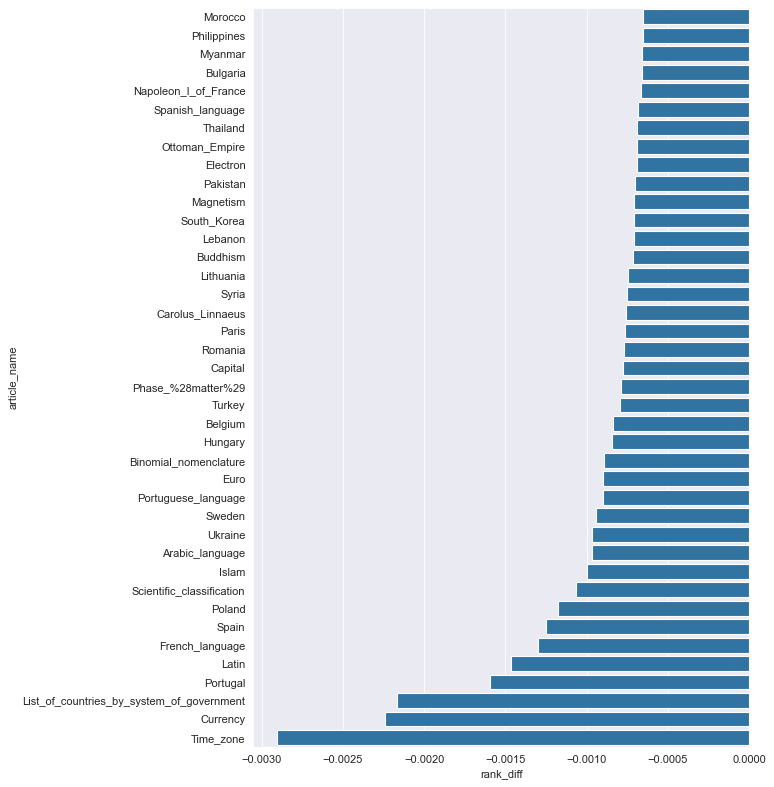

In [25]:
plt.figure(figsize=(8, 12), dpi=80)
sns.barplot(rank_v_freq_by_diff.tail(40), y='article_name', x='rank_diff', orient='y')

<Axes: xlabel='article_name'>

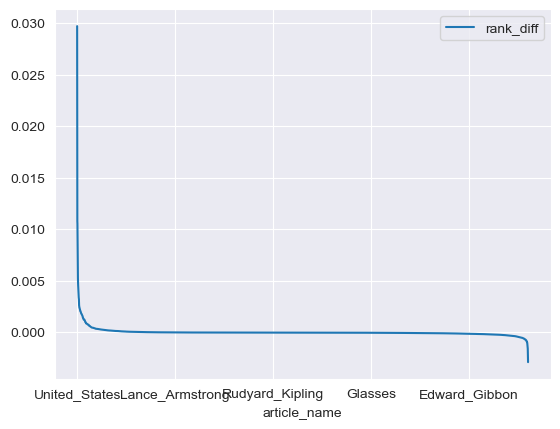

In [26]:
rank_v_freq_by_diff.plot(x='article_name', y='rank_diff')

In [27]:
print(rank_v_freq_2_columns['rank_players'].sum(), rank_v_freq_2_columns['rank_pagerank'].sum())

1.0 1.0


In [28]:
rank_v_freq_non_zero = rank_v_freq_2_columns[rank_v_freq_2_columns['rank_pagerank'] > 0] # Chi-square test requires non-zero expected frequencies, and we know all 0 frequencies also have an observed freq of 0, so we can simply remove them

In [29]:
# p-value for significance of divergence in distribution
chisquare(rank_v_freq_non_zero['rank_players'], rank_v_freq_non_zero['rank_pagerank'])

Power_divergenceResult(statistic=1.1073384471771721, pvalue=1.0)